## Autoencoder for dimensionality reduction

#### Data Preparation:

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import datasets as ds

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')


#Clusterers
from sklearn.cluster import DBSCAN

#Sampling
from sklearn.model_selection import train_test_split, ParameterGrid

#For mapper
import gtda.plotting
from gtda.mapper import (
    CubicalCover,
    make_mapper_pipeline,
    Projection,
    plot_static_mapper_graph,
    plot_interactive_mapper_graph
)
from mapper_utils import *

#For filter functions and measurements
from sklearn.decomposition import PCA
from scipy.stats import entropy

#For reproducibility
rs = 12345
from numpy.random import seed
seed(rs)
from tensorflow.random import set_seed
set_seed(rs)
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


#### Import FMNIST data and adapt the label to the 3 main categories

In [2]:
'''
0: footwear = {5:'sandal',7:'sneaker',9:'ankle_boot'}

1: accessories = {8:'bag'}

2: other = {0:'t-shirt',1:'trouser',2:'pullover',3:'dress',4:'coat',6:'shirt'}


every = {0:'t-shirt',
            1:'trouser',
            2:'pullover',
            3:'dress',
            4:'coat',
            5:'sandal',
            6:'shirt', 
            7:'sneaker',
            8:'bag',
            9:'ankle_boot'}



0: footwear, 1:accesories, 2:other 
''';

In [3]:
(xtrain,ytrain), (xtest,ytest) = ds.fashion_mnist.load_data()

In [4]:
Xtrain = pd.DataFrame(xtrain.reshape((xtrain.shape[0], 28*28)), 
                      columns = ['pixel' + str(i) for i in range(1,28*28+1)])

Xtest = pd.DataFrame(xtest.reshape((xtest.shape[0], 28*28)), 
                      columns = ['pixel' + str(i) for i in range(1,28*28+1)])

Ytrain = pd.Series(ytrain,name='label')

Ytest = pd.Series(ytest,name='label')

train = pd.concat([Xtrain,Ytrain], axis=1)
test = pd.concat([Xtest,Ytest],axis=1)

In [5]:
footwear = {5:'sandal',7:'sneaker',9:'ankle_boot'}
accessories = {8:'bag'}
other = {0:'t-shirt',1:'trouser',2:'pullover',3:'dress',4:'coat',6:'shirt'}
every = {0:'t-shirt',1:'trouser',2:'pullover',3:'dress',4:'coat',5:'sandal',6:'shirt',\
         7:'sneaker',8:'bag',9:'ankle_boot'}

In [6]:
for i in range(0,10):
    train[every[i]] = np.where(train['label']==i, 1, 0)
    test[every[i]] = np.where(test['label']==i, 1, 0)

In [7]:
train['footwear'] = sum([train[col] for col in footwear.values()])
train['accessories'] = sum([train[col] for col in accessories.values()])
train['other'] = sum([train[col] for col in other.values()])

test['footwear'] = sum([test[col] for col in footwear.values()])
test['accessories'] = sum([test[col] for col in accessories.values()])
test['other'] = sum([test[col] for col in other.values()])

In [8]:
train.rename(columns={'label':'o_label'}, inplace=True)
conditions = [
    (train['footwear'] == 1),
    (train['accessories'] == 1),
    (train['other'] == 1)]
choices = [0, 1, 2]
train['label'] = np.select(conditions, choices, default=-10)


test.rename(columns={'label':'o_label'}, inplace=True)
conditions = [
    (test['footwear'] == 1),
    (test['accessories'] == 1),
    (test['other'] == 1)]
choices = [0, 1, 2]
test['label'] = np.select(conditions, choices, default=-10)

In [9]:
data_train = train[[col for col in train.columns if 'pixel' in col] + ['o_label', 'label']]
data_test = test[[col for col in train.columns if 'pixel' in col] + ['o_label', 'label']]

In [10]:
X_train = data_train.drop(['label','o_label'],axis=1).astype('float32')/255
y_train = data_train['label']

X_test = data_test.drop(['label','o_label'],axis=1).astype('float32')/255
y_test = data_test['label']

In [11]:
X_train.shape, X_test.shape

((60000, 784), (10000, 784))

### Autoencoder architecture

In [12]:
act = 'sigmoid'
input_img = Input(shape=(784,))
e0 = Dense(units = 300, activation = act)(input_img)
e3 = Dense(units = 50, activation = act)(e0)
encoded = Dense(units = 2,activation = act)(e3)
d2 = Dense(units = 50, activation = act)(encoded)
d5 = Dense(units = 300, activation = act)(d2)
decoded = Dense(units = 784, activation = act)(d5) 


autoencoder = Model(input_img, decoded)

encoder = Model(input_img,encoded)

autoencoder.compile(optimizer = 'Adam', loss = 'MSE', metrics = ['MSE'])

autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 50)                15050     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 102       
_________________________________________________________________
dense_3 (Dense)              (None, 50)                150       
_________________________________________________________________
dense_4 (Dense)              (None, 300)               15300     
_________________________________________________________________
dense_5 (Dense)              (None, 784)               235984

#### Fit autoencoder

In [13]:
history = autoencoder.fit(X_train, X_train, 
                          epochs = 50,
                          shuffle = True, 
                          validation_data = (X_test,X_test))

Epoch 1/50
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0756 - MSE: 0.0756 - val_loss: 0.0575 - val_MSE: 0.0575
Epoch 2/50
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0513 - MSE: 0.0513 - val_loss: 0.0399 - val_MSE: 0.0399
Epoch 3/50
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0382 - MSE: 0.0382 - val_loss: 0.0349 - val_MSE: 0.0349
Epoch 4/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0347 - MSE: 0.0347 - val_loss: 0.0330 - val_MSE: 0.0330
Epoch 5/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0328 - MSE: 0.0328 - val_loss: 0.0318 - val_MSE: 0.0318
Epoch 6/50
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0315 - MSE: 0.0315 - val_loss: 0.0307 - val_MSE: 0.0307
Epoch 7/50
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0304 - MSE: 0.0304 - val_loss: 0.0299 - val_MSE: 0.0299
Epoch 8/50
1875/1875 [==============================] - 1

### Validation plot for the autoencoder fitting

dict_keys(['loss', 'MSE', 'val_loss', 'val_MSE'])


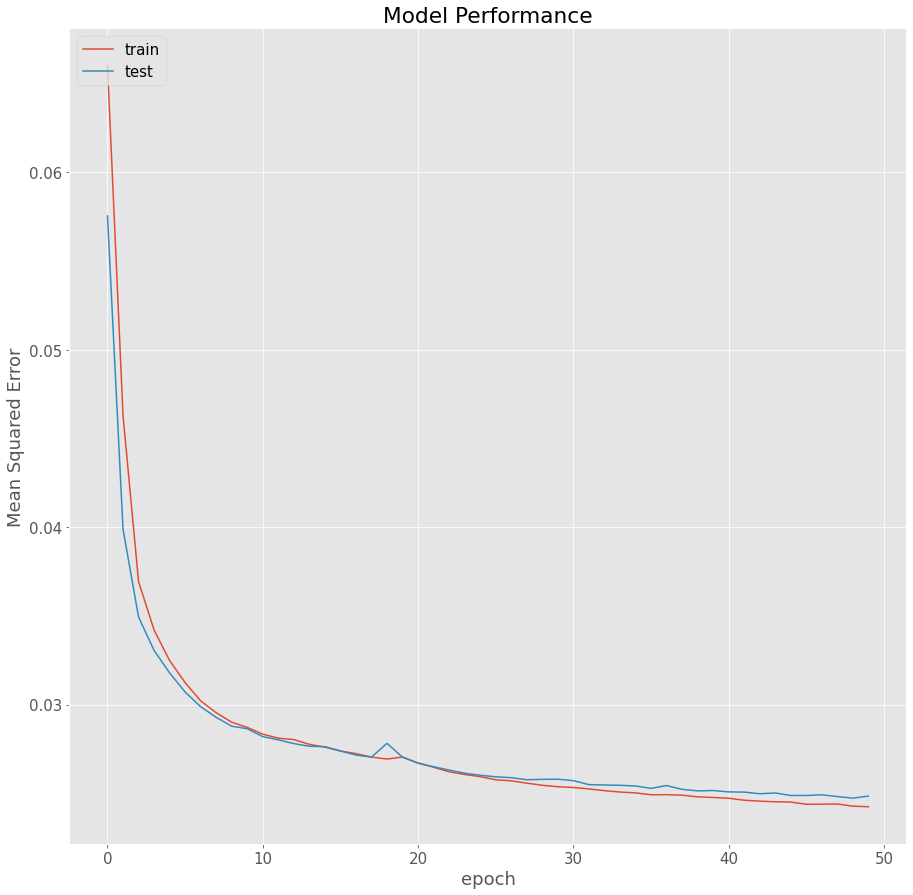

In [14]:
plt.rcParams.update({'font.size': 15})

path = 'Images/'
print(history.history.keys())
plt.figure(figsize=(15,15))
plt.plot(history.history['MSE'])
plt.plot(history.history['val_MSE'])
plt.title('Model Performance')
plt.ylabel('Mean Squared Error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(path+'AE_validation_fmnist.png', dpi = 300)
plt.show()

In [15]:
labels_dict = {0:'t-shirt',
               1:'trouser',
               2:'pullover',
               3:'dress',
               4:'coat',
               5:'sandal',
               6:'shirt',
               7:'sneaker',
               8:'bag',
               9:'ankle_boot'}

In [19]:
sample_data = pd.concat([pd.DataFrame(X_test), data_test['o_label']], axis = 1)
sample_images = []
labels = list(sample_data['o_label'].unique())
labels.sort()
for label in labels:
    image = sample_data[sample_data['o_label'] == label].sample(1, random_state = rs), label
    sample_images.append(image)

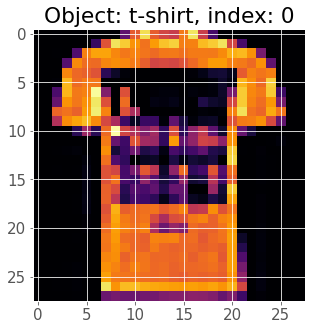

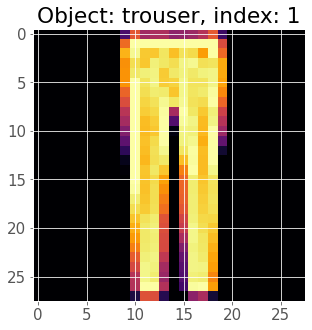

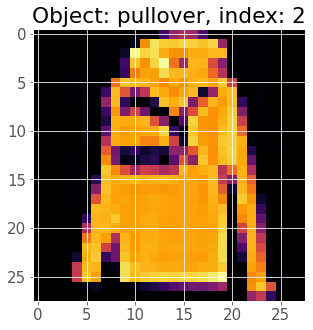

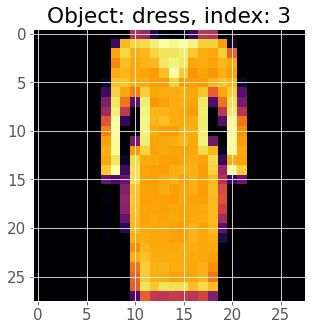

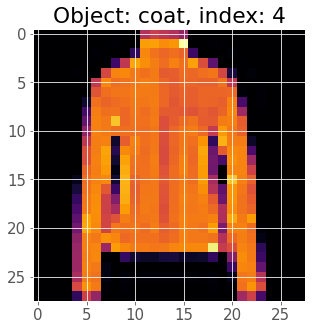

In [20]:
for i,image in enumerate(sample_images[:5]):
    x = image[0].drop('o_label',axis=1)
    plt.figure(figsize=(5,5))
    idx = list(image[0].o_label.values).pop()
    object_label = labels_dict[idx]
    plt.title('Object: ' + object_label + ', ' + 'index: ' + str(idx))
    plt.imshow(x.to_numpy().reshape(28,28), cmap = 'inferno')
    plt.savefig(path+'sample_images_' + object_label + '.png', dpi=300)

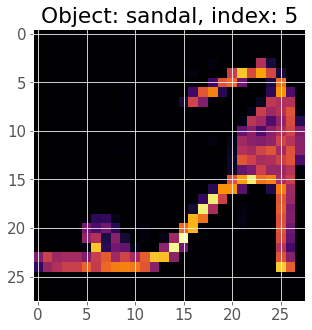

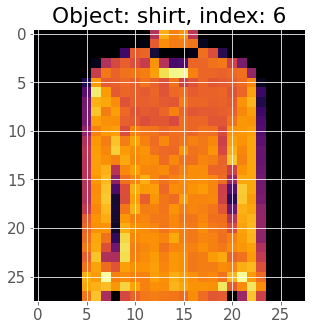

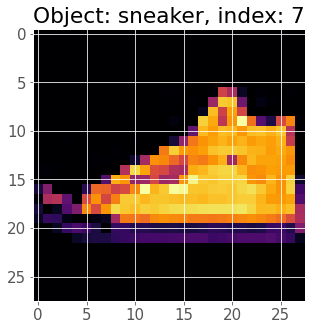

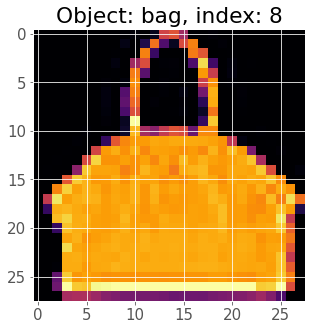

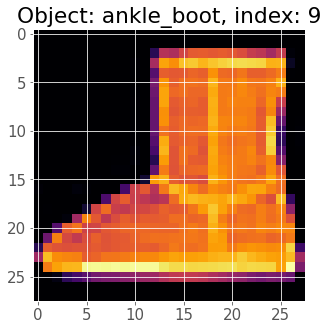

In [21]:
for i,image in enumerate(sample_images[5:]):
    x = image[0].drop('o_label',axis=1)
    plt.figure(figsize=(5,5))
    idx = list(image[0].o_label.values).pop()
    object_label = labels_dict[idx]
    plt.title('Object: ' + object_label + ', ' + 'index: ' + str(idx))
    plt.imshow(x.to_numpy().reshape(28,28), cmap = 'inferno')
    plt.savefig(path+'sample_images_' + object_label + '.png', dpi=300)

### Using the encoder to project onto a lower-dimensional space

In [22]:
proyection_test = encoder.predict(X_test)

In [23]:
P1,P2 = proyection_test[:,0],proyection_test[:,1] 

In [24]:
mapper_input_full = pd.concat((pd.Series(P1, name = 'P1'), pd.Series(P2, name = 'P2'), \
pd.Series(y_test,name='label'), X_test), axis=1)

In [25]:
mapper_input_full

,P1,P2,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.133131,0.198238,0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,0.876476,0.431629,2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.007843,0.011765,0.0,0.011765,0.682353,0.741176,0.262745,0.0,0.0,0.0
2,0.128782,0.998798,2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.643137,0.227451,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,0.133780,0.737552,2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.003922,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
4,0.697516,0.296633,2,0.0,0.0,0.0,0.007843,0.0,0.003922,0.003922,...,0.278431,0.047059,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.122236,0.095361,0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
9996,0.146480,0.683362,2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
9997,0.499232,0.302892,1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.105882,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
9998,0.217491,0.730269,2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0


### Visualizing the projection

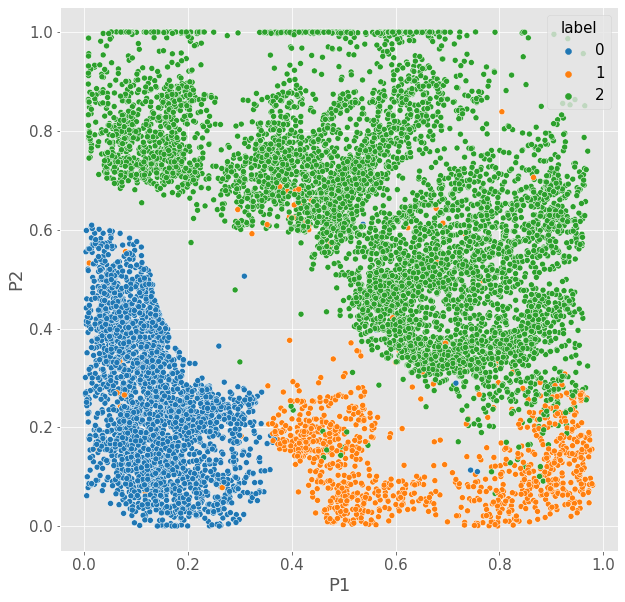

In [26]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=mapper_input_full['P1'],\
                y=mapper_input_full['P2'], hue=data_test['label'], palette='tab10')
plt.savefig(path+'FMNIST_Encoder.png',dpi=300)

In [27]:
#Save the final dataset that will be used as a mapper filter function.
mapper_input_full.to_csv('fmnist_mapper_input_full.csv')
mapper_input_full = pd.read_csv('fmnist_mapper_input_full.csv').drop('Unnamed: 0',axis=1)

### Mapper trials

In [28]:
data_ae_full = mapper_input_full[:]
data_pca = mapper_input_full.drop(['P1', 'P2'],axis=1)

In [29]:
data_ae_full

,P1,P2,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.133131,0.198238,0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,0.876476,0.431629,2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.007843,0.011765,0.0,0.011765,0.682353,0.741177,0.262745,0.0,0.0,0.0
2,0.128782,0.998798,2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.643137,0.227451,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,0.133780,0.737552,2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.003922,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
4,0.697516,0.296633,2,0.0,0.0,0.0,0.007843,0.0,0.003922,0.003922,...,0.278431,0.047059,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.122236,0.095361,0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
9996,0.146480,0.683362,2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
9997,0.499232,0.302892,1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.105882,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
9998,0.217491,0.730269,2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [30]:
data_pca

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.007843,0.011765,0.0,0.011765,0.682353,0.741177,0.262745,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.003922,...,0.643137,0.227451,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.003922,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
4,2,0.0,0.0,0.0,0.007843,0.0,0.003922,0.003922,0.0,0.000000,...,0.278431,0.047059,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
9996,2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
9997,1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.105882,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
9998,2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0


#### Sampling data (mapper is computationaly expensive)

In [31]:
X_ae_f,y_ae_f = data_ae_full.drop('label',axis=1), data_ae_full['label']

X_pca,y_pca = data_pca.drop('label',axis=1), data_pca['label']

X_ae_f_s, _, y_ae_f_s, _ = train_test_split(X_ae_f,y_ae_f, 
                                            train_size = 0.25,
                                            stratify = y_ae_f, 
                                            random_state = rs)

X_pca_s, _, y_pca_s, _ = train_test_split(X_pca,y_pca, 
                                          train_size = 0.25,
                                          stratify = y_pca, 
                                          random_state = rs)

In [32]:
all_labels = y_pca_s.values
all_value, all_counts = np.unique(all_labels, return_counts=True)
all_entropy = entropy(pk = all_counts/len(all_labels))

print('Entropy of the data: ' + str(all_entropy))
print('Counts: ' + str(all_counts))

Entropy of the data: 0.8979457248567797
Counts: [ 750  250 1500]


### PCA2 and Autoencoder bottleneck visualizations

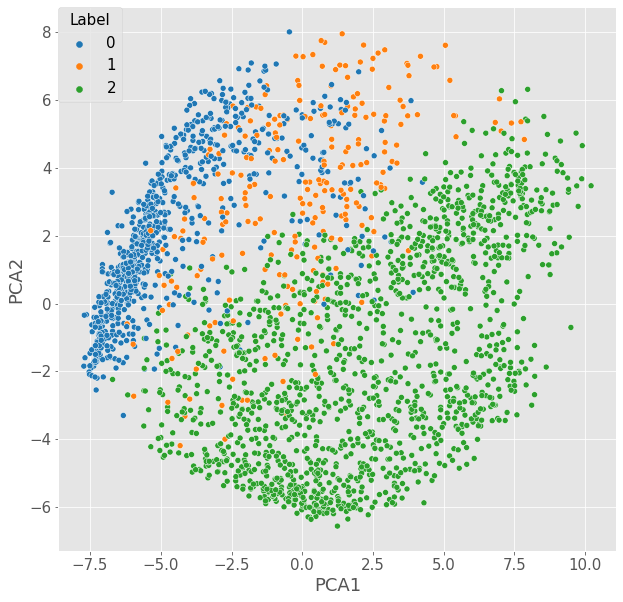

In [33]:
pca = PCA(n_components=2, random_state=rs)
p1 = pca.fit_transform(X_pca_s)
plt.figure(figsize=(10,10))
g = sns.scatterplot(x=p1[:,0], y=p1[:,1], hue=y_pca_s, palette='tab10')
g.set(xlabel='PCA1', ylabel='PCA2')
g.legend(bbox_to_anchor=(0, 1), loc=2, borderaxespad=0., title='Label')
plt.savefig(path+'fminstPCA2viz.png', dpi = 300);

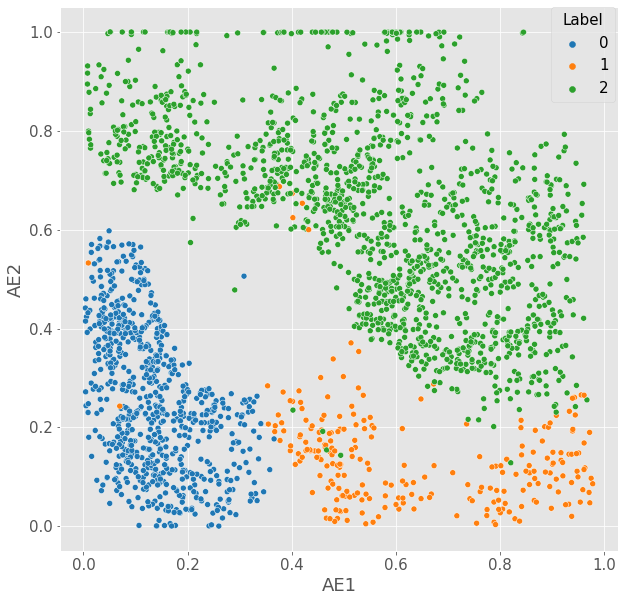

In [34]:
plt.figure(figsize=(10,10))
g = sns.scatterplot(x=X_ae_f_s['P1'], y=X_ae_f_s['P2'], hue=y_ae_f_s, palette='tab10')
g.set(xlabel='AE1', ylabel='AE2')
g.legend(bbox_to_anchor=(0.88, 1), loc=2, borderaxespad=0., title='Label')
plt.savefig(path+'fmnistAutoencoderviz.png', dpi = 300)

### Defining the parameter grids for the trials

In [35]:
hyperparams_pca = {'eps': [0.5, 1],
                   'min_samples':[3, 5],
                   'n_intervals': [int(step) for step in np.linspace(10, 30, 12)],
                   'overlap_frac': [0.1, 0.25, 0.5],
                   'lense': ['pca'],
                   'n_components': [2]}




param_grid_pca = ParameterGrid(hyperparams_pca)
hyperparams_pca

{'eps': [0.5, 1],
 'min_samples': [3, 5],
 'n_intervals': [10, 11, 13, 15, 17, 19, 20, 22, 24, 26, 28, 30],
 'overlap_frac': [0.1, 0.25, 0.5],
 'lense': ['pca'],
 'n_components': [2]}

In [36]:
Mapper_info_pca = get_mappers(param_grid=param_grid_pca, X_m=X_pca_s, y_m=y_pca_s, rs=rs)

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.2s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.2s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   2.9s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.2s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.2s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.6s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.1s
[Pipel

[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.8s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   1.2s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.2s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   1.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   1.5s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.2s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.6s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   1.6s
[Pipel

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.2s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.5s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.2s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.5s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.1s
[Pipel

[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.2s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.5s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   1.7s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.2s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   1.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   2.1s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.3s
[Pipel

[Pipeline] ........ (step 2 of 3) Processing clustering, total=   1.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.2s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.2s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.5s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.2s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.2s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.6s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.3s
[Pipel

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.2s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.8s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   3.0s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.3s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   1.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   3.3s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.1s
[Pipel

[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.9s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.3s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.2s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.5s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.4s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.2s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.5s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.4s
[Pipel

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.2s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.3s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   1.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   3.3s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.3s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   1.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   3.9s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.2s
[Pipel

In [37]:
hyperparams_ae = {'eps': [0.5, 1],
                   'min_samples':[3, 5],
                   'n_intervals': [int(step) for step in np.linspace(10, 30, 12)],
                   'overlap_frac': [0.1, 0.25, 0.5],
                   'lense': ['autoencoder'],
                   'n_components': [2]}

param_grid_ae = ParameterGrid(hyperparams_ae)
hyperparams_ae

{'eps': [0.5, 1],
 'min_samples': [3, 5],
 'n_intervals': [10, 11, 13, 15, 17, 19, 20, 22, 24, 26, 28, 30],
 'overlap_frac': [0.1, 0.25, 0.5],
 'lense': ['autoencoder'],
 'n_components': [2]}

In [38]:
Mapper_info_ae = get_mappers(param_grid=param_grid_ae, X_m=X_ae_f_s, y_m=y_ae_f_s, rs=rs)

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.5s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.6s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.1s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipel

[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.7s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   1.6s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   1.5s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   2.1s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   1.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   2.0s
[Pipel

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.6s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.2s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.7s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.2s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipel

[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.7s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   1.9s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.2s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.2s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   1.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   2.3s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.8s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   2.3s
[Pipel

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.5s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.4s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.6s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.3s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipel

[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.8s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   2.4s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.9s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   4.0s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.7s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   3.0s
[Pipel

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.5s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.4s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.6s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.5s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipel

[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.8s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   3.3s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   1.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   3.8s
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.1s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.2s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.8s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   3.8s
[Pipel

In [39]:
Results_pca = Mapper_info_pca[:]
Results_ae = Mapper_info_ae[:]
Results_pca['lense'] = 'PCA'
Results_ae['lense'] = 'Autoencoder'

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [40]:
Mappers = pd.concat((Results_pca,Results_ae), axis=0)
Mappers.to_csv('FMNIST_comparison.csv')

In [41]:
sns.set(rc={'figure.figsize':(15,10)})
sns.set_style("whitegrid", {"axes.facecolor": ".95", 'axes.labelcolor': '.25',\
                          'figure.facecolor': 'white', 'text.color': '.25',\
                           'font.family': ['DejaVu Sans']})
sns.set_context({"font.size": 15,
            "axes.labelsize": 15,
            "axes.titlesize": 15,
            "xtick.labelsize": 15,
            "ytick.labelsize": 15,
            "legend.fontsize": 15,
            "legend.title_fontsize": 15})

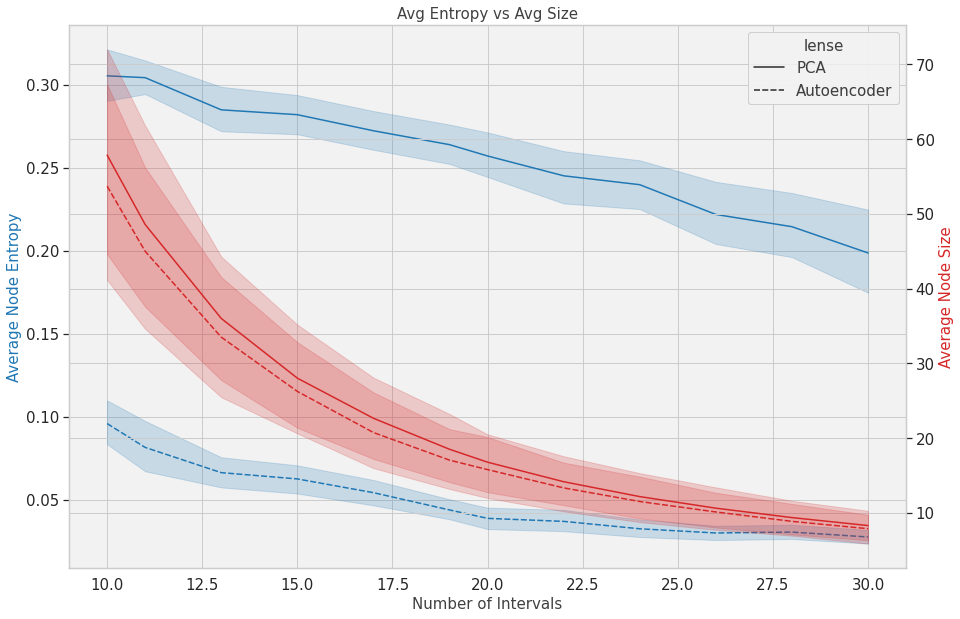

In [42]:
fig, ax1 = plt.subplots(figsize=(15,10))
ax1.set_title('Avg Entropy vs Avg Size')
ax1.set_xlabel('Number of Intervals')
ax1.set_ylabel('Average Node Entropy', color = 'tab:blue')
ax2 = sns.lineplot(x='Number of Intervals', y='Average Node Entropy', data = Mappers,\
                color = 'tab:blue', style = 'lense')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
ax2.set_ylabel('Average Node Size', color = 'tab:red')
ax2 = sns.lineplot(x='Number of Intervals', y='Average Node Size', data = Mappers,\
                   color = 'tab:red', style = 'lense')
ax2.tick_params(axis='y')
plt.show()

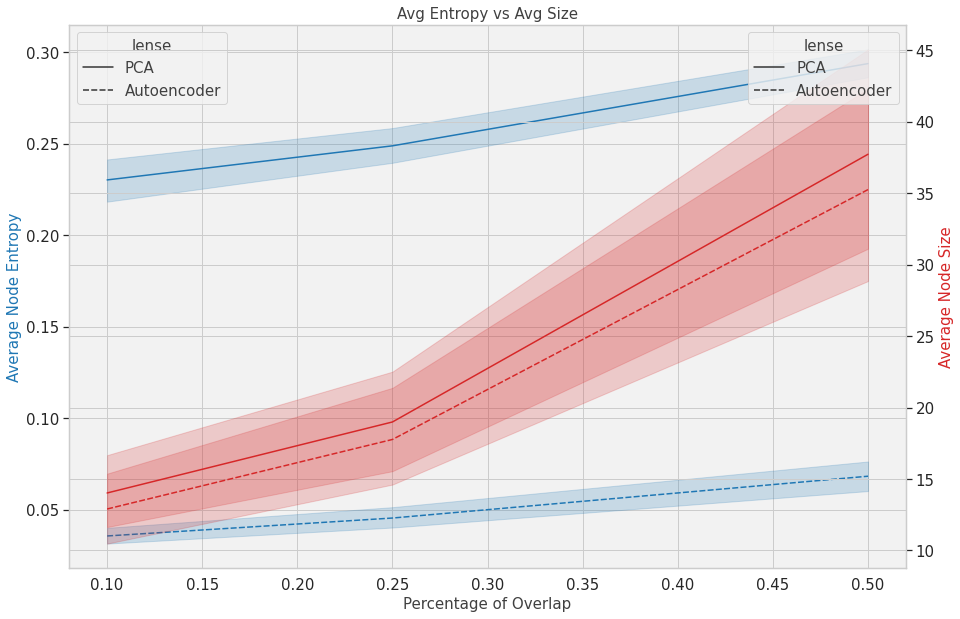

In [43]:
fig, ax1 = plt.subplots(figsize=(15,10))
ax1.set_title('Avg Entropy vs Avg Size')
ax1.set_xlabel('Percentage of Overlap')
ax1.set_ylabel('Average Node Entropy', color = 'tab:blue')
ax2 = sns.lineplot(x='Percentage of Overlap', y='Average Node Entropy', data = Mappers,\
                color = 'tab:blue', style = 'lense')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
ax2.set_ylabel('Average Node Size', color = 'tab:red')
ax2 = sns.lineplot(x='Percentage of Overlap', y='Average Node Size', data = Mappers,\
                   color = 'tab:red', style = 'lense')
ax2.tick_params(axis='y')
plt.show()

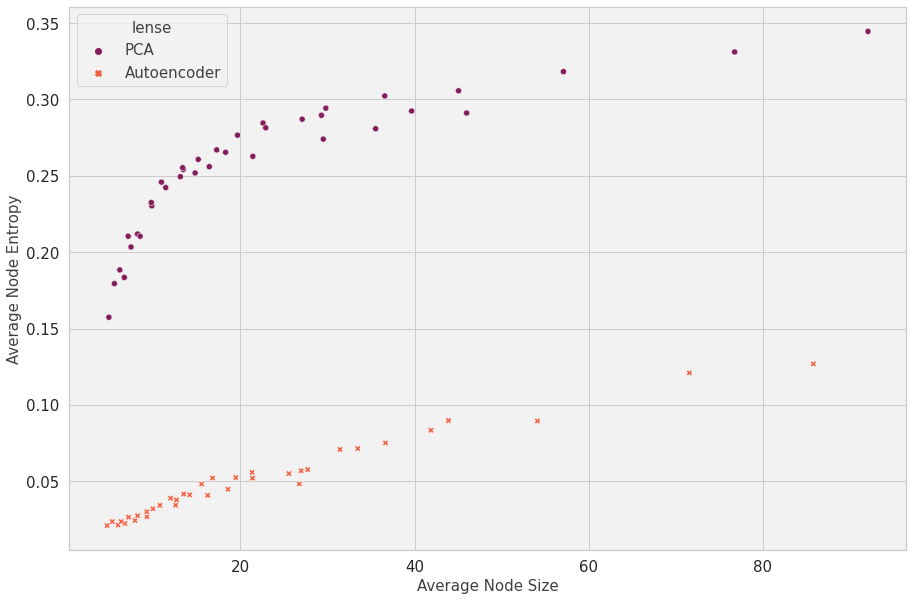

In [44]:
sns.scatterplot(x = "Average Node Size", y = "Average Node Entropy",
                 palette = 'rocket',
                 hue = 'lense',
                 style = 'lense',
                 data = Mappers)
plt.savefig(path+'FMNIST_AEvsPCA_results.png',dpi=300)

In [106]:
selected_params = {
    'n_intervals': 15,#11,
    'overlap_frac': 0.25,#0.1,
    'eps': 1.0,
    'min_samples': 3
}

In [107]:
# Define filter function
filter_func_pca = PCA(n_components = 2)

# Define cover
cover_pca = CubicalCover(n_intervals=selected_params['n_intervals'],
                         overlap_frac=selected_params['overlap_frac'])

# Choose clustering algorithm - default is DBSCAN
clusterer_pca = DBSCAN(eps = selected_params['eps'], min_samples = selected_params['min_samples'])

# Configure parallelism of clustering step
n_jobs = -1

#plotly_params = {"node_trace": {"marker_colorscale":'viridis'}}

# Initialise pipeline
selected_pipe_pca = make_mapper_pipeline(
    filter_func=filter_func_pca,
    cover=cover_pca,
    clustering_preprocessing= None, 
    clusterer=clusterer_pca,
    graph_step=True,
    verbose=False,
    n_jobs=n_jobs,
    contract_nodes = False,
)

In [127]:
fig_pca = plot_interactive_mapper_graph(selected_pipe_pca, 
                                        X_pca_s,
                                        layout="fr",
                                        color_by_columns_dropdown=False, 
                                        node_color_statistic=lambda x: np.argmax(np.bincount(x)),
                                        color_variable = y_pca_s.values)

In [128]:
fig_pca

In [116]:
# Define filter function
filter_func_ae_f = Projection(columns = ['P1', 'P2'])

# Define cover
cover_ae_f = CubicalCover(n_intervals=selected_params['n_intervals'],
                          overlap_frac=selected_params['overlap_frac'])

# Choose clustering algorithm - default is DBSCAN
clusterer_ae_f = DBSCAN(eps = selected_params['eps'], min_samples = selected_params['min_samples'])


# Configure parallelism of clustering step
n_jobs = 1

# Initialise pipeline
selected_pipe_ae_f = make_mapper_pipeline(
    filter_func=filter_func_ae_f,
    cover=cover_ae_f,
    clustering_preprocessing= None, 
    clusterer=clusterer_ae_f,
    graph_step=True,
    verbose=False,
    n_jobs=n_jobs,
    contract_nodes = False
)

In [227]:
fig_ae = plot_interactive_mapper_graph(selected_pipe_ae_f,
                                       X_ae_f_s,
                                       layout="fr",
                                       color_by_columns_dropdown=False,
                                       node_color_statistic=lambda x: np.argmax(np.bincount(x)),
                                       color_variable = y_ae_f_s.values)

In [391]:
fig_ae

In [229]:
#Generate mapper graph and its nodes and observations in each node
graph = selected_pipe_ae_f.fit_transform(X_ae_f_s)
node_elements = graph.vs["node_elements"]
node_ids = graph.vs["pullback_set_label"]
subg_info = data_test[:]
subg_compare = X_ae_f_s.merge(subg_info, how = 'inner', left_index = True, right_index = True)
columns_compare = [col for col in subg_info if 'pixel' not in col ]
subgroups = subg_compare[columns_compare]
every = {0:'t-shirt',
         1:'trouser',
         2:'pullover',
         3:'dress',
         4:'coat',
         5:'sandal',
         6:'shirt',
         7:'sneaker',
         8:'bag',
         9:'ankle_boot'}

In [530]:
#Select interesting node in the mapper (node id in hovering label)

#footware manifold 0: 15 (highankleboot) 20,21(sandal + sneaker), 47 (highsandal) 31(ankleboot sandal sneaker)
#44(tall ankleboot), 6(95 sneaker, sandal)
# 7 & 22 sneaker sandal, sandal sneaker.

# bag manifold 1: 194 - 93 -83

#regions: 
#footware manifold
# 1: [55,56, 69,70, 43, 44, 29, 30, 15, 16, 0, 1] (94 ankleboot sandal), 
# 2: [2,17,31, 3, 18, 32] (1/3 ankleboot, sandal, sneaker)
# 3: [33, 19, 4, 5, 20, 34] (1/2 sneaker sandal)
# 4: [6,21,35] (72 sneaker sandal)
# 5: [45,46,57,58] (94 sandal ankle boot)


#1. [55,56,69,70] 85 high ankleboot, high sandal

#other manifold

#1: [13,14,27,28,53,54,41,42,68, 12, 26, 40, 52, 11, 25, 39, 10, 24, 38, 37] (97 trousers)
#2: [135,136,137, 149, 150, 151,166] (75 tshirt shirt)
#3: [172,173,186,187, 198, 199] 1/2 pullover coat
#4: [177, 178, 191, 192] 1/3 coat shirt
#5: [66,67,78,79] 95 dress tshirt


#large:

#[171,172,173,185,186,187,156,157,158,198,199] 46+31 pullover+coat
#[130,131,144,145] 1/3 pullover coat shirt
#[99,100,114,115] shirt pullover
#[89,90,104,105] tshirt dress shirt mix

#example regions:

#[89,90,104,105] mixed manifold
#[66,67,78,79] dress manifold
#[13,14,27,28,53,54,41,42,68, 12, 26, 40, 52, 11, 25, 39, 10, 24, 38, 37] trouser manifold
#[135,136,137, 149, 150, 151,166] tshirt manifold

nodes_of_interest = [135,136,137, 149, 150, 151,166]

datapoints = list(set().union(*[set(node_elements[node]) for node in nodes_of_interest]))
#Get columns to reconstruct images
cols = [col for col in X_ae_f_s.columns if 'pixel' in col]

#Extract the atributes (pixels) of the observations of each node
relevant_info = X_ae_f_s.iloc[datapoints][cols]

#Extract label info
sg = subgroups.iloc[datapoints]

#Generate info for table visualization
sg['Labels ' + '(' + str(len(sg)) + ' observations)'] = sg['o_label'].replace(every);

sg['Percentages of ' + 'node ' + str(nodes_of_interest)] = sg['o_label']

df = ((sg.groupby('Labels ' + '(' + str(len(sg)) + ' observations)')
       .count()
       .sort_values(by = 'Percentages of ' + 'node ' + str(nodes_of_interest),
                    ascending = False)/len(sg)))[['Percentages of ' + 'node ' + str(nodes_of_interest)]]

cm = sns.light_palette("green", as_cmap=True)

df.style.format({'Percentages of ' + 'node ' + str(nodes_of_interest): "{:.2%}"}).background_gradient(cmap=cm)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,"Percentages of node [135, 136, 137, 149, 150, 151, 166]"
Labels (80 observations),
t-shirt,78.75%
shirt,20.00%
dress,1.25%


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



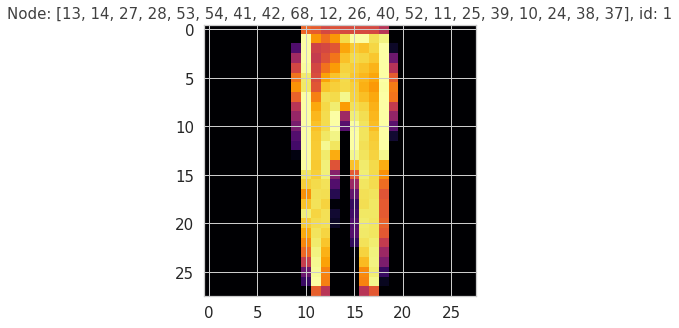

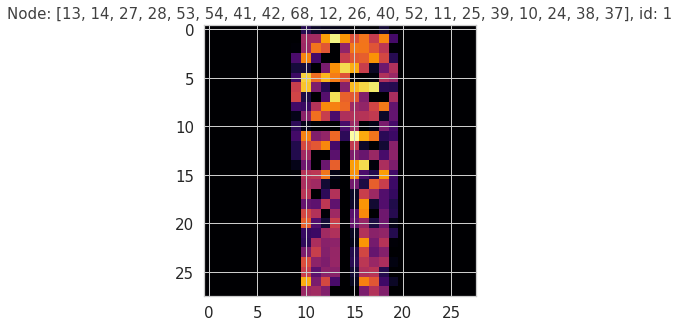

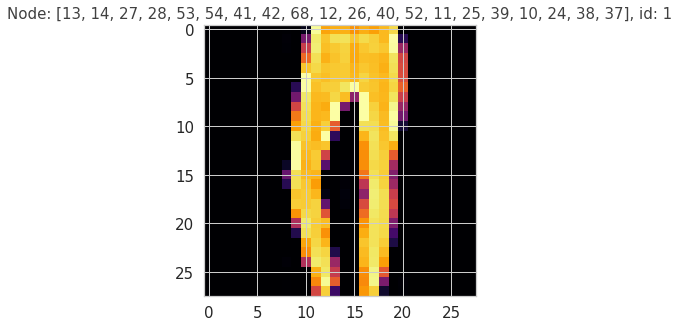

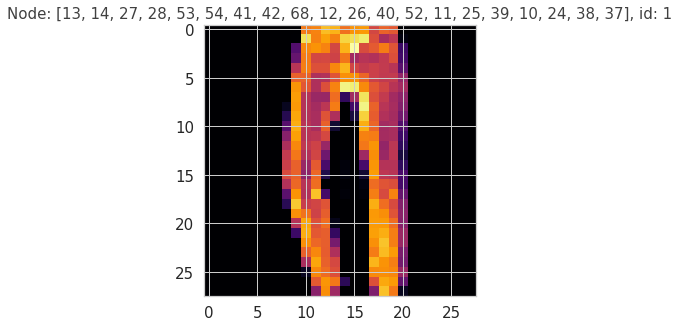

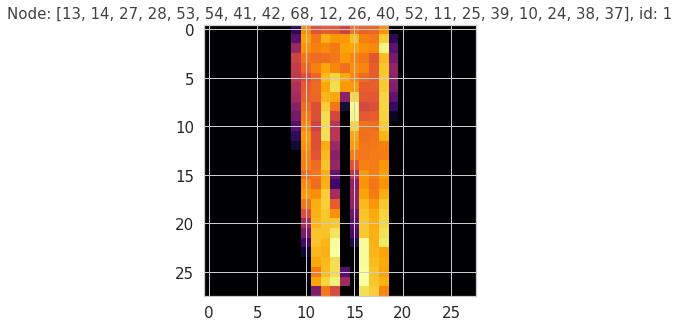

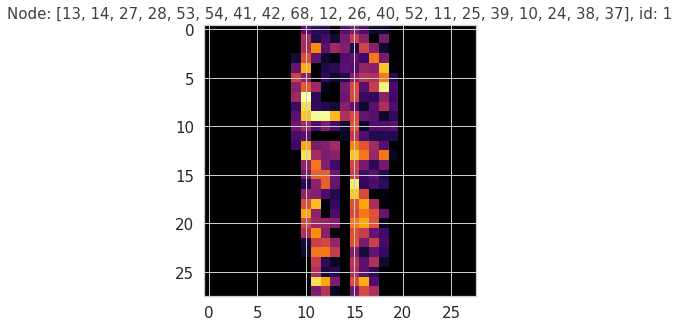

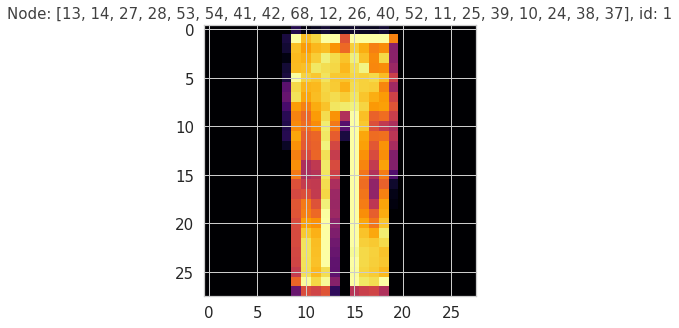

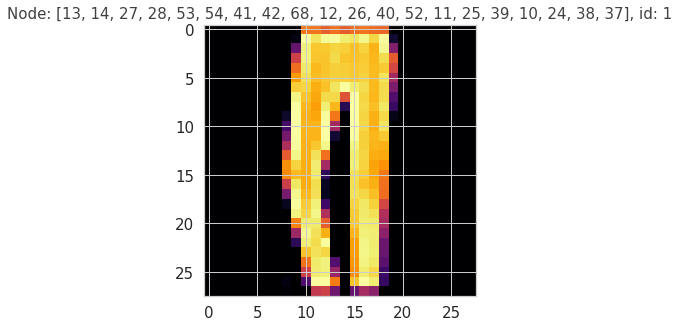

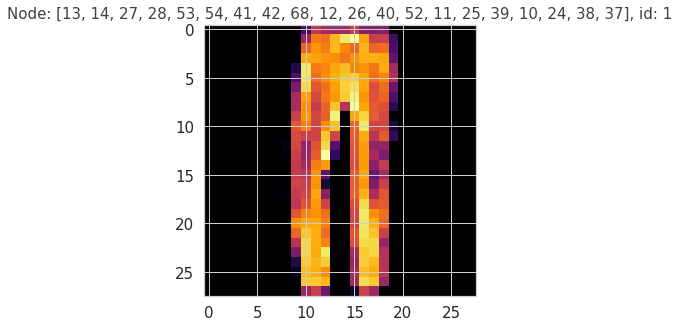

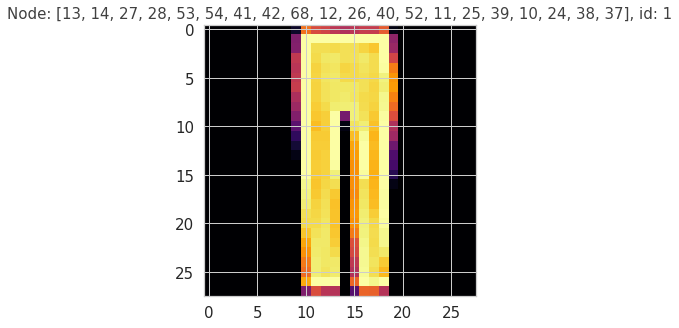

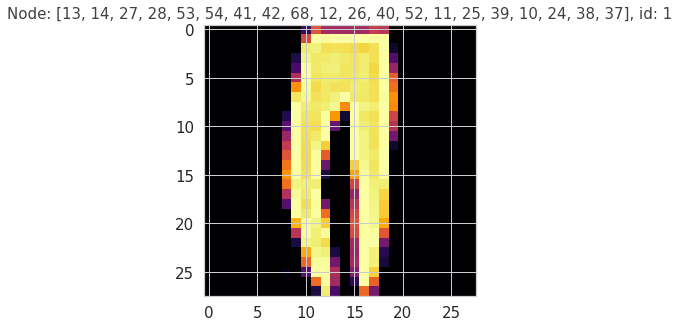

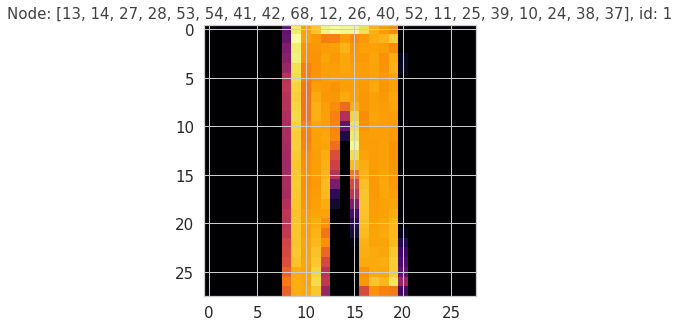

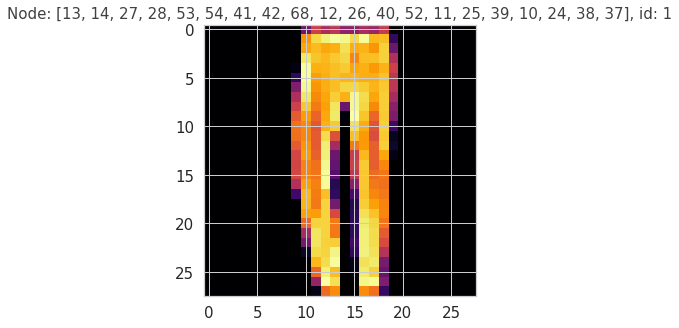

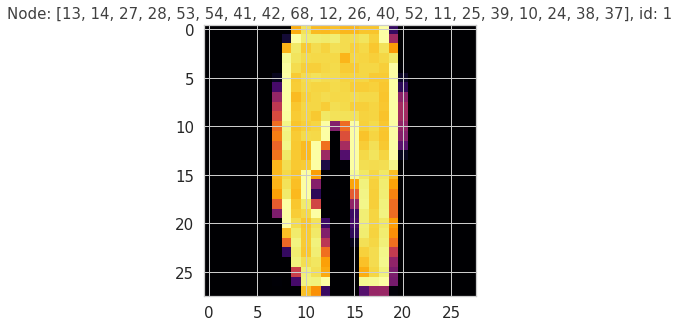

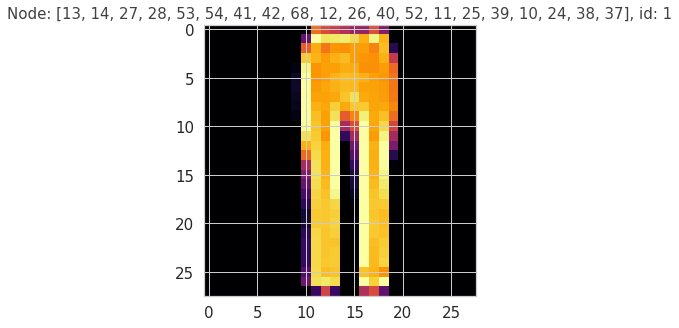

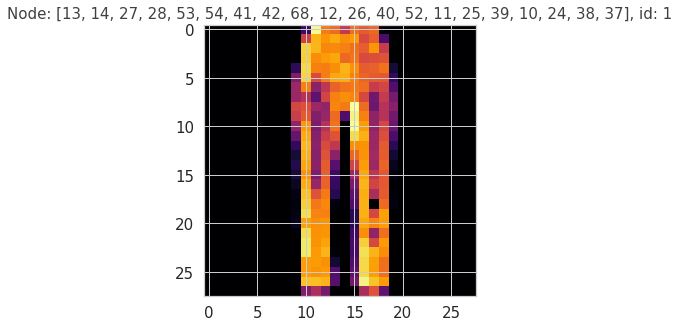

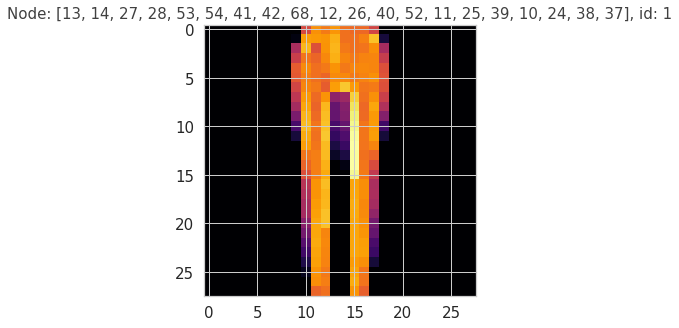

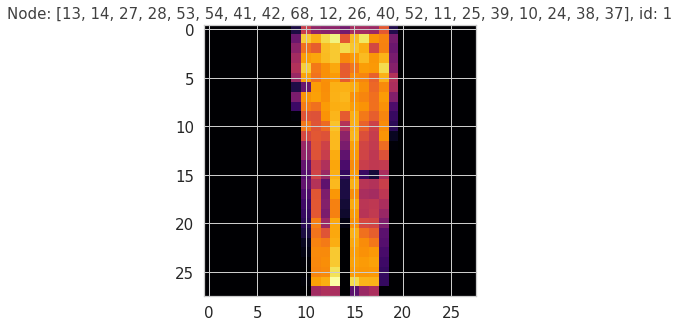

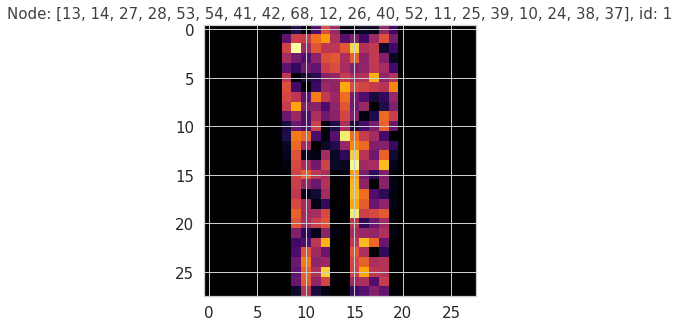

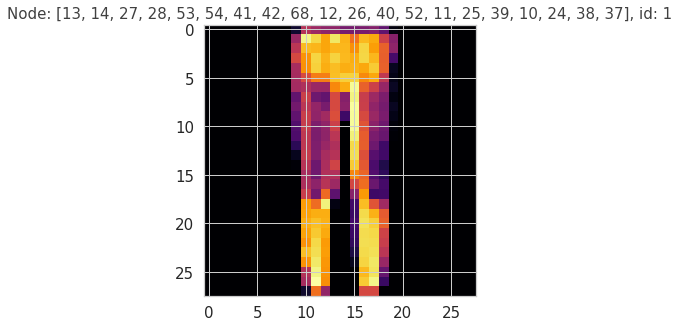

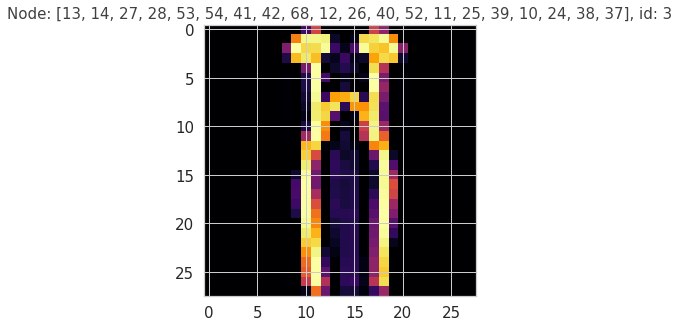

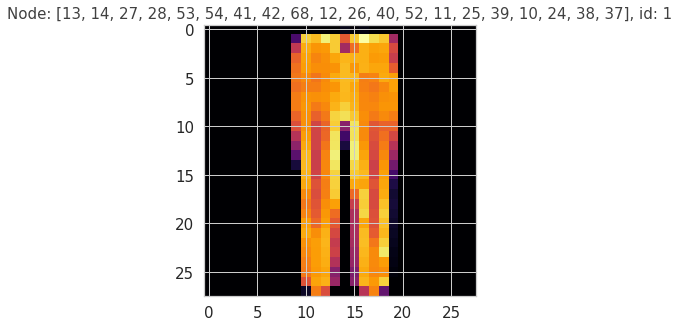

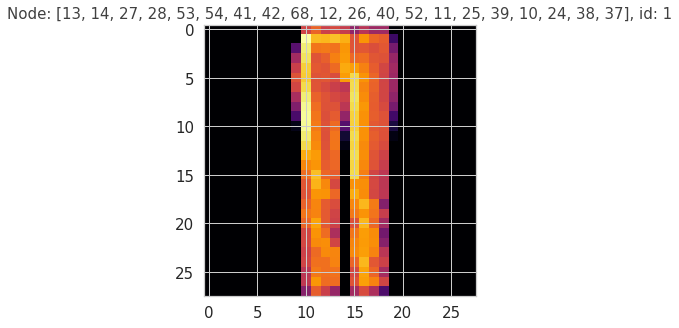

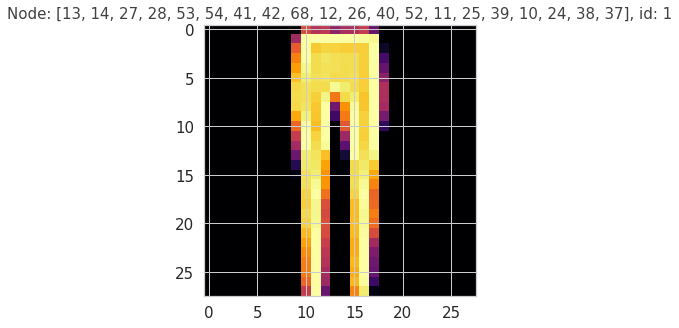

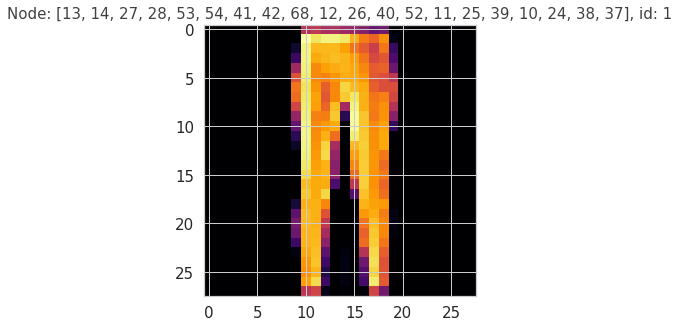

In [527]:
#See the pictures of at most 5 of the observations

i = 0
for idx, row in relevant_info.iterrows():
    i = i+1
    if i <= 25:
        plt.figure(figsize=(5,5))
        plt.title('Node: ' + str(nodes_of_interest) + ', id: ' + str(subgroups.loc[idx]['o_label']))
        plt.imshow(row.to_numpy().reshape(28,28), cmap = 'inferno')
        #plt.savefig(path+'sample_node_images_' + object_label + '.png', dpi=300)